# Image Denoising using Deep Learning

Removing noise is a challenging problem. Becuase capturing images from CT scan in Medical Imaging to DSLR camera in normal photos different noises doesn't relate to one another. By using Deep Learning we can generate good images by passing noise images with corresponding good image as the label.

In this task I am using encoders for getting features (means downsampling) and decoders(upsampling). In the case of downsampling I had used [`Convolutional Neural Network`](https://en.wikipedia.org/wiki/Convolutional_neural_network) which is helpful for feature extraction. In the upsampling case I had used [`Transported Convolution`](https://en.wikipedia.org/wiki/Deconvolution) which leads to original image size in the end. I had updated filters using backpropagation technique  with different hyperparameters.

Here, I am using [`PyTorch`](https://pytorch.org/) a Machine Learning framework to perform this task.

## Data Preprocessing

For this task I am using [`CIFAR10`](https://www.cs.toronto.edu/~kriz/cifar.html) dataset which consists of 50000 training images and 10000 testing images of size 32x32x3. Here 32x32 represents height and depth of the image 3 represents color channels (r, g, b) of the image.  

In [ ]:
""" Importing all the necessary libraries """

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision

In [ ]:
""" Normaling and Transforming to Tensors"""

transform_train = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose([ 
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
"""     Here I'm downloading the datasets. We can download the dataset by using torchvision library """

trainset = torchvision.datasets.CIFAR10( root = './cifar10', train = True, 
                                       download = True, transform = transform_train)

testset = torchvision.datasets.CIFAR10( root = './cifar10', train = False, 
                                       download = True, transform = transform_train)

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [ ]:
## Initializing batch size
batch_size = 16

In [ ]:
"""       Here I'm initializing trainloader which separates the data into batch sizes of 16. 
                    That means each bacth size we have 16 images. For the entire 5000 images, trainloader is aggregating 
                    them to 3125 batches.
          """
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [ ]:
""" Let's see the size of the first batch"""

dataset = iter(trainloader)
print(dataset)
images, labels = dataset.next()

print(images.shape)
print(images[1].shape)
print(labels[0])

torch.Size([16, 3, 32, 32])
torch.Size([3, 32, 32])
tensor(6)


In [ ]:

""" Our aim here is Denoise the noise image using Deep Learning. Lets add the noise to image and visualize"""

def visualize_data(data):

    for i, data in enumerate(data, 0):
        k = np.random.randint(16)
        images, labels = data
        images = images.numpy()
        image = np.transpose(images[k], (1, 2, 0))
        noise = np.random.normal(loc = 0.52, scale= 0.12, size = images.shape)
        noise_images = images + noise
        torch_noise_images = torch.from_numpy(noise_images)
        npimg = torch_noise_images[k].numpy()
        npimg = np.transpose(npimg, (1, 2, 0))
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
        ax1.imshow(image)
        ax1.set_title("Original Image")
        ax2.imshow(npimg)
        ax2.set_title(" Noisy Image")

        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


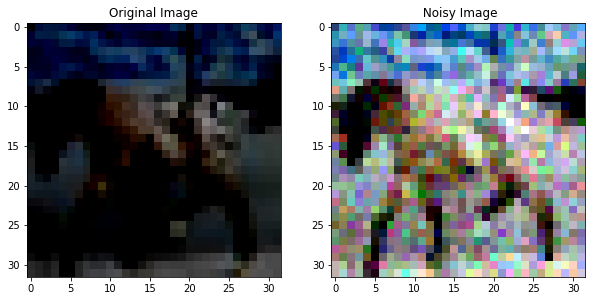

In [ ]:
## Visualing the Original Image and noisy image

visualize_data(trainloader)

## Network building

Here, In the encoder phase I'm using convilutional layer and then followed by [`ReLU`](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) activation function for non-linearity. In decoder phase phase I am using transported convolution for producing same as the input.


In [ ]:

""" Implementing Network class """

class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, 3),
            nn.ReLU(),
            nn.Conv2d(6, 16, 3),
            nn.ReLU())
        self.decoder = nn.Sequential(             
            nn.ConvTranspose2d(16, 6, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(6, 3, 3),
            nn.ReLU())
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

The dataset containes 50000 datasets which takes some more time to train. So I am using [`GPU`](https://en.wikipedia.org/wiki/Graphics_processing_unit) for this task.

In [ ]:

"""" The below code produces cuda:0 if is available otherwise cpu"""
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


## Training

I am using large large number of epochs for convergence to global minima. I had tried with Adam and SGD optimizers with different hyperparameters. You can find their graphical results in `Hyperparameter tuning` section.
I found SGD was performing starting from first epoch. Here, I am using [`Mean Squared Error`](https://en.wikipedia.org/wiki/Mean_squared_error) becuase we are not classifying. In the final we are comparing output image from the network to the original image. 

In [ ]:
      
epochs = 100
net = Network().to(device)
loss_fn = nn.MSELoss()
opt = optim.SGD(net.parameters(), lr = 0.1) 

In [ ]:


      """" trainloader loads both images and their corresponding labels, we don't labels here"""

%%time
loss_on_epochs = []
for epoch in range(epochs):
    for data in trainloader:
        images, _ = data

        images_copy = images.numpy()

        #""" The below code was adding noise to the batch of images each time"""
        noise = np.random.normal(loc = 0.52, scale= 0.12, size = images_copy.shape)
        noise_images = images_copy + noise
        torch_noise_images = torch.from_numpy(noise_images)
        
        #""" Moving original images and noise images to the device (means GPU)"""
        images = images.to(device)

        torch_noise_images = torch_noise_images.to(device)
       
       #""" Passing noise images to the network"""
        output = net(torch_noise_images.float())
        
        #""" Computing loss"""
        loss = loss_fn(output, images)

        #""" Setting gradiants to zero initially"""
        opt.zero_grad()

        #"""" Computing gradiants using backward pass and updating weights"""
        loss.backward()
        opt.step()
        
        #""" Book keeping of loss on each epoch"""
    loss_on_epochs.append(loss.item())
    if (epoch + 1) % 10 == 0:
      print('epoch {}/{} ========> loss:{:.4f}'.format(epoch+1, epochs, loss.item()))

epoch 10/100 ========> loss:0.1801
epoch 20/100 ========> loss:0.1828
epoch 30/100 ========> loss:0.1746
epoch 40/100 ========> loss:0.1664
epoch 50/100 ========> loss:0.2126
epoch 60/100 ========> loss:0.2030
epoch 70/100 ========> loss:0.1326
epoch 80/100 ========> loss:0.1128
epoch 90/100 ========> loss:0.1157
epoch 100/100 ========> loss:0.1114
CPU times: user 33min 45s, sys: 25.7 s, total: 34min 11s
Wall time: 34min 19s


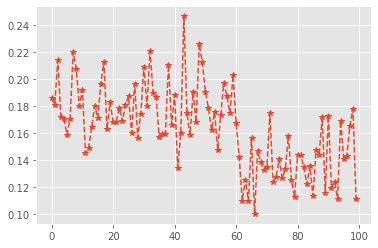

In [ ]:

""" Plotting losses """

plt.style.use('ggplot')
plt.plot(loss_on_epochs, '*--')

## Testing



In [ ]:

""" Here also, I am using testloader like trianloader for loading batch of images each iteration"""

testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False)

In [ ]:

""" Let's have a look at the sizes of the data"""
data = iter(testloader)
img, _ = data.next()
print(img.shape)
print(img[1].shape)

torch.Size([16, 3, 32, 32])
torch.Size([3, 32, 32])


In [ ]:

""" We have to pass noise image to the dataset which gives us the unnoisy image"""

datatest = iter(testloader)

images, _ = datatest.next()

""" Adding noise the batch of images"""
images_copy = images.numpy().copy()
noise = np.random.normal( loc = 0.52, scale = 0.12, size= images_copy.shape)


noisy_images = images_copy + noise

torch_noisy_images = torch.from_numpy(noisy_images).to(device)


""" Making predictions by passing batch of images to the model. In the final make sure the size of the output should be same as input"""
predictions = net(torch_noisy_images.float())
print(predictions.shape)


torch.Size([16, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([16, 32, 32, 3])
torch.Size([16, 32, 32, 3])
torch.Size([16, 32, 32, 3])


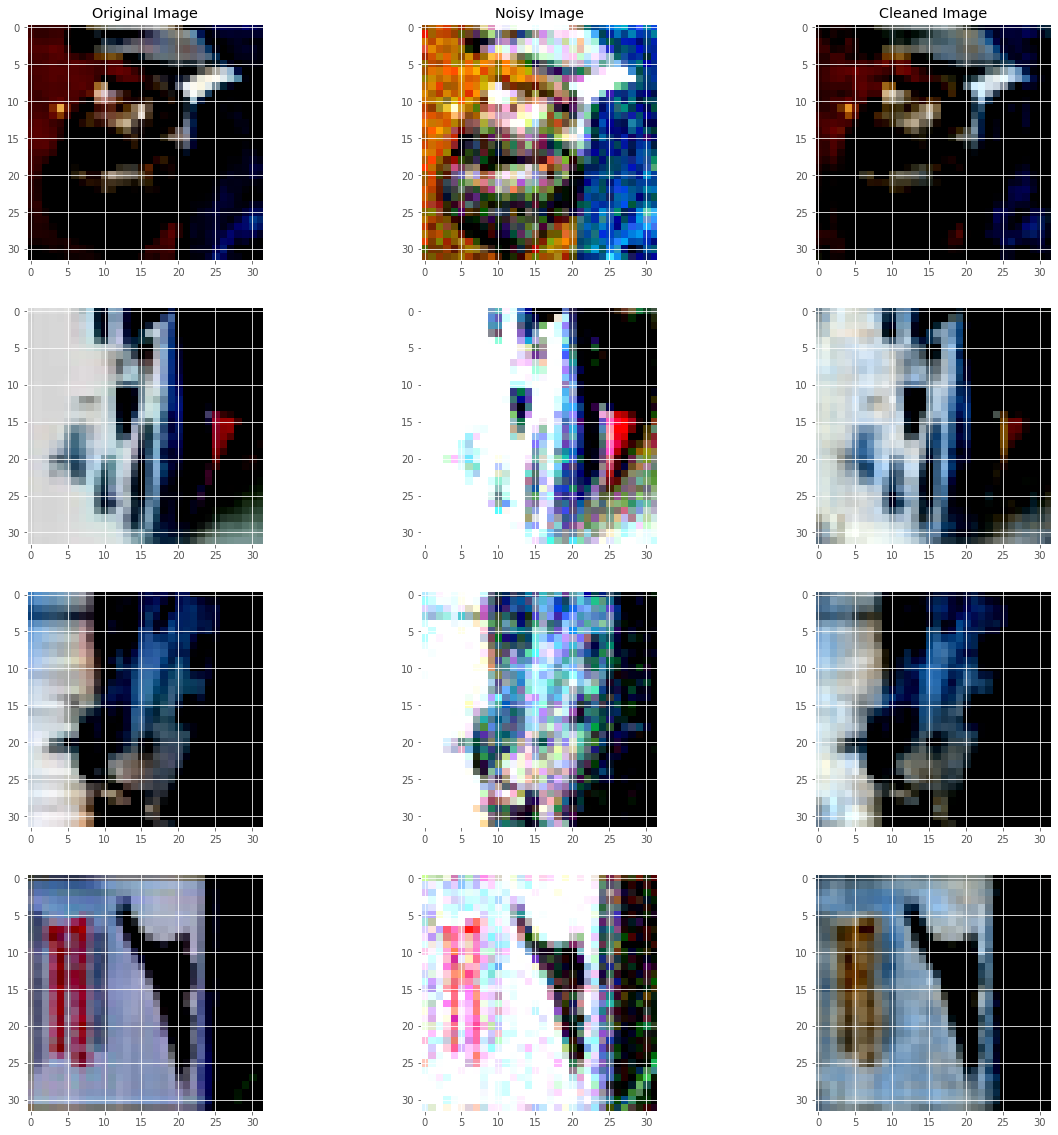

In [ ]:

""" Plotting the resulted images"""

fig, ax = plt.subplots(4, 3, figsize = (20, 20))
ax[0, 0].set_title("Original Image")
ax[0, 1].set_title("Noisy Image")
ax[0, 2].set_title("Cleaned Image")

images = images.permute(0, 3, 2, 1)
print(images.shape)
torch_noisy_images = torch_noisy_images.permute(0, 3, 2, 1)
print(torch_noisy_images.shape)
predictions = predictions.permute(0, 3, 2, 1)
print(predictions.shape)

for i in range(4):

  ax[i, 0].imshow(images[i].cpu().detach().numpy())
  ax[i, 1].imshow(torch_noisy_images[i].cpu().detach().numpy())
  ax[i, 2].imshow(predictions[i].cpu().detach().numpy()) 


## Hyperparameter tuning

Hyperparameter tuning involves trying and experimenting a lot of things with hyperparameters. Here I had tried with two popular optimizers [`Adam`](https://arxiv.org/pdf/1412.6980.pdf) and [`Stochastic Gradient Descent`](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) with different learning rates. For better understanding I had made plots. 

 


In [ ]:

# """ Here, I am creating lists for learning rates and optimizers. 
#       For book keeping of individual losses I am using loss_optim_results dictionary. 
#       Anyone can change optimizers and learning rates and also add other hyperparameters. 
#       """

%%time
learning_rates = [0.1, 0.1, 0.01, 0.01, 0.001, 0.001, 0.0001, 0.0001, 0.00001,0.00001]
optimisers = [optim.SGD(net.parameters(), lr = 0.1), optim.Adam(net.parameters(), lr = 0.1),
              optim.SGD(net.parameters(), lr = 0.01), optim.Adam(net.parameters(), lr = 0.01),
              optim.SGD(net.parameters(), lr = 0.001), optim.Adam(net.parameters(), lr = 0.001),
              optim.SGD(net.parameters(), lr = 0.0001), optim.Adam(net.parameters(), lr = 0.0001),
              optim.SGD(net.parameters(), lr = 0.00001), optim.Adam(net.parameters(), lr = 0.00001)]

loss_optim_results = dict()
for i, optimizer in tqdm(enumerate(optimisers)):
  if (i+1) % 2 != 0.0:
    string = "loss_results_SGD_"+ str(learning_rates[i])
  else:  
    string = "loss_results_Adam_"+ str(learning_rates[i-1])
  print("Optimizer with learning rate =======>", string[13:])
  epochs = 20
  loss_on_epochs = []

#""" Below code is same as training code in the above, 
#  here I am trying with different hyperparameters with different learning rates in a loop.
#  """
  for epoch in range(epochs):
      for data in trainloader:

        images, _ = data

        images_copy = images.numpy()
        noise = np.random.normal(loc = 0.52, scale= 0.12, size = images_copy.shape)
        noise_images = images_copy + noise
        torch_noise_images = torch.from_numpy(noise_images)
        images = images.to(device)

        torch_noise_images = torch_noise_images.to(device)
        
        output = net(torch_noise_images.float())
          
        loss = loss_fn(output, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
      loss_on_epochs.append(round(loss.item(), 4))
  loss_optim_results[string] = loss_on_epochs
      
 













0it [00:00, ?it/s]

Optimizer with learning rate =======> SGD_0.1














1it [06:53, 413.61s/it]

Optimizer with learning rate =======> Adam_0.1














2it [14:41, 430.01s/it]

Optimizer with learning rate =======> SGD_0.01














3it [21:52, 430.10s/it]

Optimizer with learning rate =======> Adam_0.01














4it [29:46, 443.45s/it]

Optimizer with learning rate =======> SGD_0.001














5it [37:03, 441.48s/it]

Optimizer with learning rate =======> Adam_0.001














6it [45:18, 457.62s/it]

Optimizer with learning rate =======> SGD_0.0001














7it [52:38, 452.31s/it]

Optimizer with learning rate =======> Adam_0.0001














8it [1:00:33, 458.95s/it]

Optimizer with learning rate =======> SGD_1e-05














9it [1:07:48, 451.89s/it]

Optimizer with learning rate =======> Adam_1e-05














10it [1:15:54, 455.44s/it]

CPU times: user 1h 14min 44s, sys: 52.5 s, total: 1h 15min 37s
Wall time: 1h 15min 54s


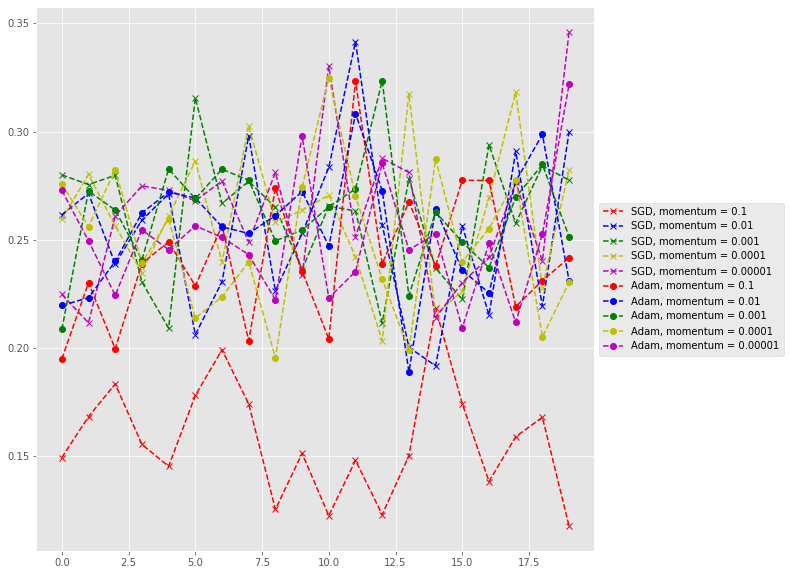

In [ ]:

""" Plotting the results. I know the below plots are too messy. 
          I had made a individual plots in below with learning rates in both Adam and SGD.
          As if you clearly observe you can see SGD with learning rate 0.01 perform from starting point onwards.
          So, I had used SGD with momentum in my model. We can use others as well.
      """
plt.figure(figsize= (10 , 10))

plt.plot((loss_optim_results['loss_results_SGD_0.1']), 'x--',  color = 'r', label = "SGD, momentum = 0.1")
plt.plot((loss_optim_results['loss_results_SGD_0.01']), 'x--', color = 'b', label = "SGD, momentum = 0.01")
plt.plot((loss_optim_results['loss_results_SGD_0.001']), 'x--', color = 'g', label = "SGD, momentum = 0.001")
plt.plot((loss_optim_results['loss_results_SGD_0.0001']), 'x--', color = 'y', label = "SGD, momentum = 0.0001")
plt.plot((loss_optim_results['loss_results_SGD_1e-05']), 'x--', color = 'm', label = "SGD, momentum = 0.00001")


plt.plot((loss_optim_results['loss_results_Adam_0.1']), 'o--',  color = 'r', label = "Adam, momentum = 0.1")
plt.plot((loss_optim_results['loss_results_Adam_0.01']), 'o--', color = 'b', label = "Adam, momentum = 0.01")
plt.plot((loss_optim_results['loss_results_Adam_0.001']), 'o--', color = 'g', label = "Adam, momentum = 0.001")
plt.plot((loss_optim_results['loss_results_Adam_0.0001']), 'o--', color = 'y', label = "Adam, momentum = 0.0001")
plt.plot((loss_optim_results['loss_results_Adam_1e-05']), 'o--', color = 'm', label = "Adam, momentum = 0.00001")

plt.legend( loc = "center left", bbox_to_anchor=(1, 0.5))

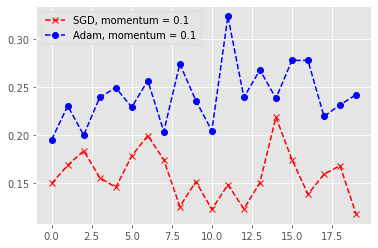

In [ ]:

""" Plotting with learning rate 0.1 in SGD and Adam"""
plt.plot((loss_optim_results['loss_results_SGD_0.1']), 'x--',  color = 'r', label = "SGD, momentum = 0.1")
plt.plot((loss_optim_results['loss_results_Adam_0.1']), 'o--',  color = 'b', label = "Adam, momentum = 0.1")
plt.legend()

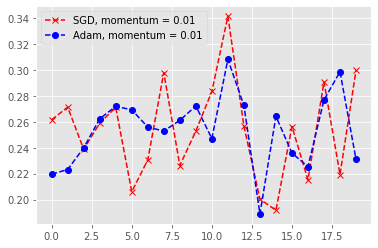

In [ ]:

""" Plotting with learning rate 0.01 in SGD and Adam"""
plt.plot((loss_optim_results['loss_results_SGD_0.01']), 'x--', color = 'r', label = "SGD, momentum = 0.01")
plt.plot((loss_optim_results['loss_results_Adam_0.01']), 'o--', color = 'b', label = "Adam, momentum = 0.01")
plt.legend()

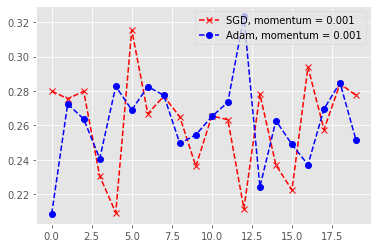

In [ ]:

""" Plotting with learning rate 0.001 in SGD and Adam"""
plt.plot((loss_optim_results['loss_results_SGD_0.001']), 'x--', color = 'r', label = "SGD, momentum = 0.001")
plt.plot((loss_optim_results['loss_results_Adam_0.001']), 'o--', color = 'b', label = "Adam, momentum = 0.001")
plt.legend()

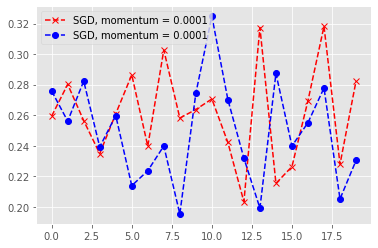

In [ ]:

""" Plotting with learning rate 0.0001 in SGD and Adam"""
plt.plot((loss_optim_results['loss_results_SGD_0.0001']), 'x--', color = 'r', label = "SGD, momentum = 0.0001")
plt.plot((loss_optim_results['loss_results_Adam_0.0001']), 'o--', color = 'b', label = "SGD, momentum = 0.0001")
plt.legend()

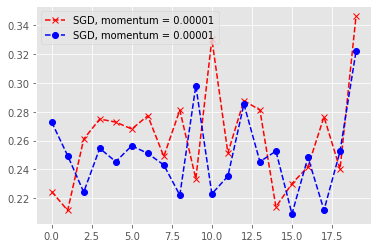

In [ ]:

""" Plotting with learning rate 0.00001 in SGD and Adam"""
plt.plot((loss_optim_results['loss_results_SGD_1e-05']), 'x--', color = 'r', label = "SGD, momentum = 0.00001")
plt.plot((loss_optim_results['loss_results_Adam_1e-05']), 'o--', color = 'b', label = "SGD, momentum = 0.00001")
plt.legend()